# Session Content :
1. meaning of Pretrained model and Fine Tuning Methodelgy(Slides 5)
2. Pretrained Model in Keras (Notebook)


# Pre-Trained Models
Though it is often necessary to have a large, well annotated dataset to solve a deep learning challenge, there are many freely available pre-trained models that we can use right out of the box. As you decide to take on your own deep learning project, it is a great idea to start by looking for existing models online that can help you achieve your goal. A great place to explore available models is [NGC](https://catalog.ngc.nvidia.com/models). There are also many models hosted on GitHub that you can find through searching on Google.

![Pre-Trained Model](https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-fine-tune-architecture-feature-image-2-1536x1232.png)

## An Automated Doggy Door

In this session, we will be creating a doggy door that only lets dogs (and not other animals) in and out. We can keep our cats inside, and other animals outside where they belong. Using the techniques covered so far, we would need a very large dataset with pictures of many dogs, as well as other animals. Luckily, there is a readily available model that has been trained on a massive dataset, including lots of animals.

## Loading the Model

We will start by downloading the model. Trained ImageNet models are available to download directly within the Keras library. You can see the available models and their details [here](https://keras.io/api/applications/#available-models). Any of these models would work for our exercise. We will pick a commonly used one called [VGG16](https://keras.io/api/applications/vgg/#vgg16-function):
![](https://miro.medium.com/v2/resize:fit:1400/0*6VP81rFoLWp10FcG)

In [28]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Dropout
from tensorflow.keras.utils import to_categorical
from keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt
import random

In [ ]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [26]:
# load the VGG16 network *pre-trained* on the ImageNet dataset
model = VGG16(weights="imagenet")

Now that it is loaded, let us take a look at the model. It looks a lot like our convolutional model from the session 7 . Pay attention to the first layer (the input layer) and the last layer (the output layer). As with our earlier Sessions, we need to make sure our images match the input dimensions that the model expects. It is also valuable to understand what the model will return from the final output layer.

In [27]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## input dimensions
We can see that the model is expecting images in the shape of (224, 224, 3) corresponding to 224 pixels high, 224 pixels wide, and 3 color channels. As we learned in our last Session, Keras models can accept more than one image at a time for prediction. If we pass in just one image, the shape will be (1, 224, 224, 3). We will need to make sure that when passing images into our model for prediction, they match these dimensions.

## Output dimensions
We can also see that the model will return a prediction of shape 1000. Remember that in our Session 7 the output shape of our model was 10, corresponding to the 10 different digits. In our second exercise we had a shape of 24, corresponding to the 24 letters of the sign language alphabet that could be captured in a still image. Here, we have 1000 possible categories that the image will be placed in. Though the full ImageNet dataset has over 20,000 categories, the competition and resulting pre-trained models just use a subset of 1000 of these categories. We can take a look at all of these possible categories [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

Many of the categories are animals, including many types of dogs and cats. The dogs are categories 151 through 268. The cats are categories 281 through 285. We will be able to use these categories to tell our doggy door what type of animal is at our door, and whether we should let them in or not.

## Load Dataset


In [21]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [22]:
# Normalize pixel values between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [23]:
# One-hot encode the labels
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)


## Base Model

In [25]:
# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3),classes=train_labels.shape[1])

In [30]:
# Create a new model on top of the pre-trained model
model1 = Sequential()
model1.add(base_model)
model1.add(Flatten())
#Add the Dense layers along with activation and batch normalization
model1.add(Dense(1024,activation=('relu'),input_dim=512))
model1.add(Dense(512,activation=('relu')))
model1.add(Dense(256,activation=('relu')))
model1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model1.add(Dense(128,activation=('relu')))
model1.add(Dropout(.2))
model1.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [32]:
# Freeze the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False


In [33]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)


In [34]:
# Compile the model

model1.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [35]:
# Train the model
history = model1.fit(train_images, train_labels,
                    epochs=50,
                    batch_size=100,
                    validation_data=(test_images, test_labels))

Epoch 1/50
500/500 [==============================] - 14s 22ms/step - loss: 1.6548 - accuracy: 0.4059 - val_loss: 1.4091 - val_accuracy: 0.4935
Epoch 2/50
500/500 [==============================] - 10s 21ms/step - loss: 1.4022 - accuracy: 0.5082 - val_loss: 1.3121 - val_accuracy: 0.5323
Epoch 3/50
500/500 [==============================] - 9s 18ms/step - loss: 1.3238 - accuracy: 0.5361 - val_loss: 1.2657 - val_accuracy: 0.5507
Epoch 4/50
500/500 [==============================] - 9s 18ms/step - loss: 1.2784 - accuracy: 0.5536 - val_loss: 1.2385 - val_accuracy: 0.5689
Epoch 5/50
500/500 [==============================] - 9s 18ms/step - loss: 1.2413 - accuracy: 0.5686 - val_loss: 1.2455 - val_accuracy: 0.5599
Epoch 6/50
500/500 [==============================] - 9s 18ms/step - loss: 1.2051 - accuracy: 0.5829 - val_loss: 1.2110 - val_accuracy: 0.5771
Epoch 7/50
500/500 [==============================] - 10s 20ms/step - loss: 1.1781 - accuracy: 0.5925 - val_loss: 1.2018 - val_accuracy: 0.5

In [37]:
# Evaluate the model
test_loss, test_acc = model1.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 4s 10ms/step - loss: 1.3807 - accuracy: 0.6158
Test accuracy: 0.6158000230789185


313/313 [==============================] - 4s 10ms/step


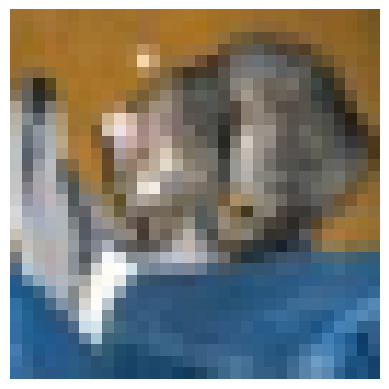

Predicted: dog | True Label: cat


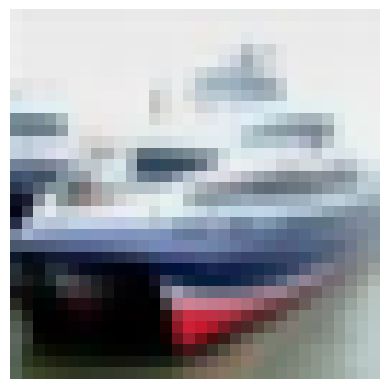

Predicted: ship | True Label: ship


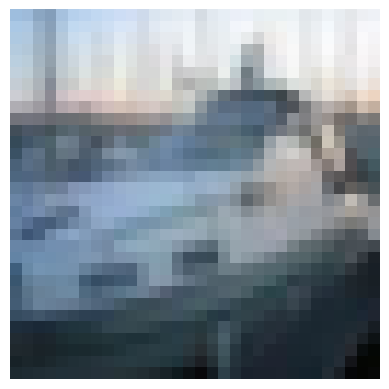

Predicted: ship | True Label: ship


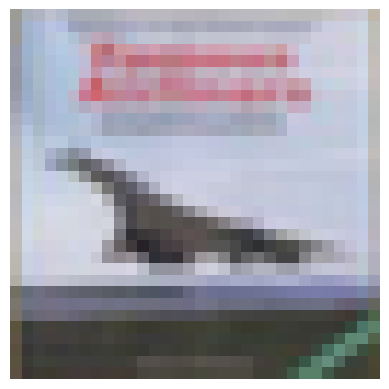

Predicted: truck | True Label: airplane


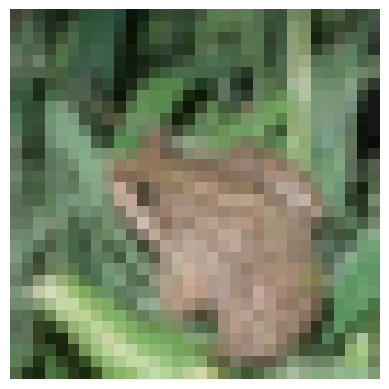

Predicted: frog | True Label: frog


In [39]:
# Predict on test images
predictions = model1.predict(test_images)

# Display some test images with predictions
num_images_to_show = 5

for i in range(num_images_to_show):
    # Display the test image
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.show()

    # Find the predicted label and the true label
    predicted_label = np.argmax(predictions[i])
    true_label = np.argmax(test_labels[i])

    # Map label indices to actual label names (for CIFAR-10)
    label_map = {
        0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
        5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
    }

    # Show the predicted and true labels
    print(f"Predicted: {label_map[predicted_label]} | True Label: {label_map[true_label]}")